In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Phase diagram predicted by the density equations

## Density equations up to $\mathcal{O}(\nabla^2 \rho_S)$

\begin{equation*}
	\partial_t \rho_S = \nabla \cdot \left(\frac{v_S}{2D_r} \nabla (v_S \rho_S)\right )
	+ D_t \Delta \rho_S + \mathcal{O}(\nabla^3\rho_S),
\end{equation*}

where $v_S$ is determined by
$$
v_S = \bar{v}_{S} \tilde{v}_{SA}\tilde{v}_{SB},
$$
with
$$
\begin{aligned}
\tilde{v}_{SA} &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\bar{\rho}_A}{\rho_0}
	\right),\\
\tilde{v}_{SB} &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\bar{\rho}_B}{\rho_0}
	\right)
\end{aligned}.
$$

The linear apporximation for $v_S$ around $(\rho_A=\bar{\rho}_A, \rho_B=\bar{\rho}_B)$ is
\begin{equation*}
	v_S = \bar{v}_{S} \left [1
	+ \eta_{S A} \frac{\rho_A (\mathbf{r}) - \bar{\rho}_{A}}{\rho_0}
	+ \eta_{S B} \frac{\rho_B (\mathbf{r}) - \bar{\rho}_{B}}{\rho_0} 
	\right ].
\end{equation*}



In [2]:
def get_tilde_v_XY(eta_XY, rho_Y, bar_rho_Y, kappa=0.7):
    return 1 + kappa * np.tanh(eta_XY/kappa * (rho_Y - bar_rho_Y))


def get_tilde_v(eta_AA, eta_AB, eta_BA, eta_BB, rho_A, rho_B, bar_rho_A, bar_rho_B, kappa=0.7):
    drho_A = rho_A - bar_rho_A
    drho_B = rho_B - bar_rho_B
    inv_kappa = 1. / kappa
    v_AA = 1 + kappa * np.tanh(eta_AA * inv_kappa * drho_A)
    v_AB = 1 + kappa * np.tanh(eta_AB * inv_kappa * drho_B)
    v_BA = 1 + kappa * np.tanh(eta_BA * inv_kappa * drho_A)
    v_BB = 1 + kappa * np.tanh(eta_BB * inv_kappa * drho_B)
    return v_AA, v_AB, v_BA, v_BB


def get_v_A(rho_A, rho_B, bar_rho_A, bar_rho_B, etaAA, etaAB, bar_v_A=1., kappa=0.7):
    v_AA = get_tilde_v_XY(etaAA, rho_A, bar_rho_A, kappa)
    v_AB = get_tilde_v_XY(etaAB, rho_B, bar_rho_B, kappa) 
    return bar_v_A * v_AA * v_AB

def get_v_B(rho_A, rho_B, bar_rho_A, bar_rho_B, etaBA, etaBB, bar_v_B=1., kappa=0.7):
    v_BA = get_tilde_v_XY(etaBA, rho_A, bar_rho_A, kappa)
    v_BB = get_tilde_v_XY(etaBB, rho_B, bar_rho_B, kappa)
    return bar_v_B * v_BA * v_BB

The spatial gradient of $v_S(\mathbf{r})$ is
$$
\begin{aligned}
\nabla v_S &= \bar{v}_S \left(
    \tilde{v}_{SB}\nabla \tilde{v}_{SA}+\tilde{v}_{SA}\nabla \tilde{v}_{SB}
\right) \\
&= \bar{v}_S \left(
    \tilde{v}_{SA}' \tilde{v}_{SB}\nabla \rho_A +
    \tilde{v}_{SA} \tilde{v}_{SB}'\nabla \rho_B
\right) \\
&= v_S \left(
    \frac{\tilde{v}'_{SA}}{\tilde{v}_{SA}} \nabla \rho_A +
    \frac{\tilde{v}'_{SB}}{\tilde{v}_{SB}} \nabla \rho_B
\right)
\end{aligned}
$$
where
$$
\begin{aligned}
\tilde{v}_{SA}'&=\partial_{\rho_A} \tilde{v}_{SA} = \frac{\eta_{SA}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SA}}{\kappa}\frac{\rho_A-\bar{\rho}_A}{\rho_0}\right)\right] = \frac{\eta_{SA}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SA}-1}{\kappa}\right)^2
\right],\\
\tilde{v}_{SB}'&=\partial_{\rho_B} \tilde{v}_{SB} = \frac{\eta_{SB}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SB}}{\kappa}\frac{\rho_B-\bar{\rho}_B}{\rho_0}\right)\right] = \frac{\eta_{SB}}{\rho_0} \left[
    1 - \left(\frac{\tilde{v}_{SB}-1}{\kappa}\right)^2
\right]
.
\end{aligned}
$$

In [3]:
def get_tilde_v_XY_derive(eta_XY, tilde_v_XY, kappa=0.7):
    return eta_XY * (1 - ((tilde_v_XY - 1)/kappa)**2)


Futhermore, the Laplacian of $v_S$ can be written as
$$
\nabla^2 v_S \approx v_S \left(
    \frac{\tilde{v}'_{SA}}{\tilde{v}_{SA}} \nabla^2 \rho_A +
    \frac{\tilde{v}'_{SB}}{\tilde{v}_{SB}} \nabla^2 \rho_B
\right),
$$
where the nonlinear terms has been ommited.

Neclecting the diffusion term and higher order terms, the density equation can be written as

$$
\begin{aligned}
\partial_t \rho_S &= \frac{1}{2D_r} \left[
	v_S^2\nabla^2 \rho_S + v_S \rho_S \nabla^2 v_S
\right] \\
&= \frac{1}{2D_r} \left[
	v_S^2 \nabla^2 \rho_S + v_S \rho_S \bar{v}_S \left(
		\tilde{v}_{SA}' \tilde{v}_{SB}\nabla^2 \rho_A +
    \tilde{v}_{SA} \tilde{v}_{SB}'\nabla^2 \rho_B
	\right)
\right] \\
& = \frac{v_S^2}{2D_r} \left[
	\nabla^2 \rho_S + \rho_S\left(
		\frac{\tilde{v}_{SA}'}{\tilde{v}_{SA}} \nabla^2 \rho_A + \frac{\tilde{v}_{SB}'}{\tilde{v}_{SB}} \nabla^2\rho_B
	\right)
\right]
\end{aligned}
$$

Expanding $\rho_S$ aound $\rho_{S,0}$, the dynamic of $\delta \rho_S$ is governed by
$$
\partial \delta \rho_S = \frac{v_{S,0}^2}{2D_r} \left[
	\nabla^2 \delta \rho_S + \psi_{SA} \nabla^2 \delta\rho_A + \psi_{SB} \nabla^2 \rho_B
\right],
$$
where
$$
\begin{aligned}
\psi_{XY} &= \rho_{X,0}\left. \left(\frac{\tilde{v}_{XY}'}{\tilde{v}_{XY}}\right)
\right|_
{\rho_Y=\rho_{Y,0}}, \\
v_{S,0} &= \bar{v}_S \left. \tilde{v}_{SA}\right|_{\rho_A=\rho_{A,0}} \left. \tilde{v}_{SB} \right|_{\rho_B=\rho_{B,0}}.
\end{aligned}
$$


Therefore, we have
$$
	\partial_t 
	\begin{pmatrix}
		\delta \rho_A \\ \delta \rho_B
	\end{pmatrix}
	= \frac{q^2}{2D_r}
	\begin{pmatrix}
		-v_{A,0}^2(1 + \psi_{AA}) & -v_{A,0}^2\psi_{AB} \\
		-v_{B,0}^2\psi_{BA} & -v_{B,0}^2(1+ \psi_{BB})
	\end{pmatrix}
	\begin{pmatrix}
		\delta \rho_A \\ \delta \rho_B
	\end{pmatrix}
$$

Defining $\varepsilon_{SS'}=-v_{S,0}^2(\delta_{SS'}+\psi_{SS'})$, the eigen values of the matrix is
$$
\lambda_{\pm} = -\mu \pm \sqrt{\Delta},
$$
with
$$
\begin{aligned}
\mu &= -\frac{\varepsilon_{AA}+\varepsilon_{BB}}{2}, \\
\Delta &= \frac{(\varepsilon_{AA}-\varepsilon_{BB})^2}{4} + \varepsilon_{AB}\varepsilon_{BA}.
\end{aligned}
$$

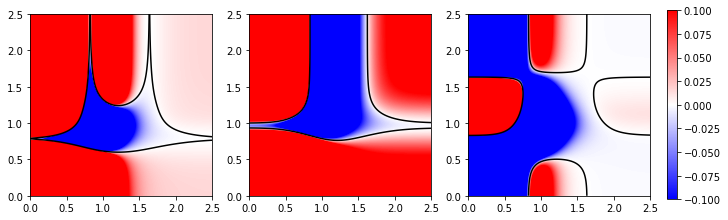

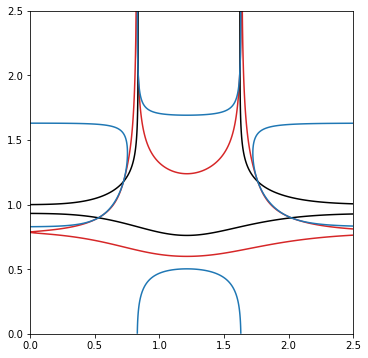

In [4]:
def get_mu(phi_A, phi_B, bar_rho_A, bar_rho_B, etaAA, etaAB, etaBA, etaBB, bar_v_A=1., bar_v_B=1., kappa=0.7):
    v_AA, v_AB, v_BA, v_BB = get_tilde_v(etaAA, etaAB, etaBA, etaBB, phi_A, phi_B, bar_rho_A, bar_rho_B, kappa)
    vA_0 = bar_v_A * v_AA * v_AB
    vB_0 = bar_v_B * v_BA * v_BB
    
    v_AA_deriv = get_tilde_v_XY_derive(etaAA, v_AA)
    v_BB_deriv = get_tilde_v_XY_derive(etaBB, v_BB)

    psi_AA = phi_A * v_AA_deriv / v_AA
    psi_BB = phi_B * v_BB_deriv / v_BB
    eps_AA = -vA_0**2 * (1 + psi_AA)
    eps_BB = -vB_0**2 * (1 + psi_BB)
    return -(eps_AA+eps_BB) * 0.5 


def get_Delta(phi_A, phi_B, bar_rho_A, bar_rho_B, etaAA, etaAB, etaBA, etaBB, bar_v_A=1., bar_v_B=1., kappa=0.7):
    v_AA, v_AB, v_BA, v_BB = get_tilde_v(etaAA, etaAB, etaBA, etaBB, phi_A, phi_B, bar_rho_A, bar_rho_B, kappa)
    vA_0 = bar_v_A * v_AA * v_AB
    vB_0 = bar_v_B * v_BA * v_BB
    
    v_AA_deriv = get_tilde_v_XY_derive(etaAA, v_AA)
    v_AB_deriv = get_tilde_v_XY_derive(etaAB, v_AB)
    v_BA_deriv = get_tilde_v_XY_derive(etaBA, v_BA)
    v_BB_deriv = get_tilde_v_XY_derive(etaBB, v_BB)

    psi_AA = phi_A * v_AA_deriv / v_AA
    psi_AB = phi_A * v_AB_deriv / v_AB
    psi_BA = phi_B * v_BA_deriv / v_BA
    psi_BB = phi_B * v_BB_deriv / v_BB

    eps_AA = -vA_0**2 * (1 + psi_AA)
    eps_AB = -vA_0**2 * (psi_AB)
    eps_BA = -vB_0**2 * (psi_BA)
    eps_BB = -vB_0**2 * (1 + psi_BB)
    return 0.25 * (eps_AA - eps_BB)**2 + eps_AB * eps_BA


def get_mu_Delta(phi_A, phi_B, bar_rho_A, bar_rho_B, etaAA, etaAB, etaBA, etaBB, bar_v_A=1., bar_v_B=1., kappa=0.7):
    v_AA, v_AB, v_BA, v_BB = get_tilde_v(etaAA, etaAB, etaBA, etaBB, phi_A, phi_B, bar_rho_A, bar_rho_B, kappa)
    vA_0 = bar_v_A * v_AA * v_AB
    vB_0 = bar_v_B * v_BA * v_BB
    
    v_AA_deriv = get_tilde_v_XY_derive(etaAA, v_AA)
    v_AB_deriv = get_tilde_v_XY_derive(etaAB, v_AB)
    v_BA_deriv = get_tilde_v_XY_derive(etaBA, v_BA)
    v_BB_deriv = get_tilde_v_XY_derive(etaBB, v_BB)

    psi_AA = phi_A * v_AA_deriv / v_AA
    psi_AB = phi_A * v_AB_deriv / v_AB
    psi_BA = phi_B * v_BA_deriv / v_BA
    psi_BB = phi_B * v_BB_deriv / v_BB

    eps_AA = -vA_0**2 * (1 + psi_AA)
    eps_AB = -vA_0**2 * (psi_AB)
    eps_BA = -vB_0**2 * (psi_BA)
    eps_BB = -vB_0**2 * (1 + psi_BB)

    mu = -(eps_AA+eps_BB) * 0.5
    Delta = 0.25 * (eps_AA - eps_BB)**2 + eps_AB * eps_BA
    return mu, Delta

etaAA = etaBB = -2
etaAB = 2
etaBA = -etaAB

x = np.linspace(0, 2.5, num=1000, endpoint=True)
y = np.linspace(0, 2.5, num=1000, endpoint=True)
xv, yv = np.meshgrid(x, y)

# bar_rho_A = xv
# bar_rho_B = yv
bar_rho_A = 1
bar_rho_B = 1
mu_v = get_mu(xv, yv, bar_rho_A, bar_rho_B, etaAA, etaAB, etaBA, etaBB)
Delta_v = get_Delta(xv, yv, bar_rho_A, bar_rho_B, etaAA, etaAB, etaBA, etaBB)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 3), constrained_layout=True)
ax1.imshow(Delta_v, origin="lower", extent=(0, x[-1], 0, y[-1]), vmax=0.1, vmin=-0.1,cmap="bwr")
ax1.contour(x, y, Delta_v, levels=[0], colors=["k"])

ax2.imshow(mu_v, origin="lower", extent=(0, x[-1], 0, y[-1]), vmax=0.1, vmin=-0.1,cmap="bwr")
ax2.contour(x, y, mu_v, levels=[0], colors=["k"])
im = ax3.imshow(Delta_v - mu_v**2, origin="lower", extent=(0, x[-1], 0, y[-1]), vmax=0.1, vmin=-0.1,cmap="bwr")
ax3.contour(x, y, Delta_v-mu_v**2, levels=[0], colors=["k"])

plt.colorbar(im)
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.contour(x, y, Delta_v, levels=[0], colors=["tab:red"])
ax.contour(x, y, mu_v, levels=[0], colors=["k"])
ax.contour(x, y, Delta_v-mu_v**2, levels=[0], colors=["tab:blue"])
ax.axis("scaled")
plt.show()
plt.close()

# phiA = 1
# phiB = 1

# eta_AA_1d = np.linspace(-3, 1.5, 1000)
# alpha_1d = np.linspace(0, 3, 1000)

# alpha, etaAA = np.meshgrid(alpha_1d, eta_AA_1d)
# etaAB = etaAA + alpha
# etaBA = etaAA - alpha
# etaBB = etaAA

# mu = get_mu(phiA, phiB, bar_rho_A, bar_rho_B, etaAA, etaAB, etaBA, etaBB)
# Delta = get_Delta(phiA, phiB, bar_rho_A, bar_rho_B, etaAA, etaAB, etaBA, etaBB)
# plt.imshow(Delta-mu**2, origin="lower", extent=[alpha_1d[0], alpha_1d[-1], eta_AA_1d[0], eta_AA_1d[-1]], vmin=-2, vmax=2, cmap="bwr")
# plt.colorbar()
# plt.show()
# plt.close()



## Density equation up to $O(\nabla^6 \rho_S)$

By letting $\partial_t f_{3,S}=0$, we get $f_{3,S}=-\frac{1}{18D_r}\nabla(v_Sf_{2,S})$, then the equation for $\rho$, $f_{1,S}$ and $f_{2,S}$ reads
$$
\begin{aligned}
    \partial_t \rho_S &= -\Re [\nabla^* (v_S f_{1,S})]  + D_t \Delta \rho_S\\
    \partial_t f_{1,S} &= -\frac{1}{2} \nabla^* (v_S f_{2,S}) - \frac{1}{2}\nabla(v_S\rho_S)
    - D_r f_{1,S} +  D_t \Delta f_{1,S},\\
    \partial_t f_{2,S} &= \frac{1}{36 D_r} \nabla^* (v_S \nabla(v_S f_{2,S})) - \frac{1}{2}\nabla(v_S f_{1,S}) - 4 D_r f_{2,S} + D_t \Delta f_{2,S}.
\end{aligned}
$$

Assuming $\partial_t f_{2,S}=0$ we get
$$
\begin{aligned}
f_{2,S} &= \frac{1}{144 D_r^2}\nabla^* (v_S\nabla(v_S f_{2,S})) - \frac{1}{8D_r} \nabla(v_S f_{1,S}) + \frac{D_t}{4D_r} \Delta f_{2,S} \\
&= \frac{1}{144 D_r^2}\nabla^* \left(v_S\nabla\left(v_S \left(-\frac{1}{8D_r} \nabla(v_S f_{1,S})\right)\right)\right) - \frac{1}{8D_r} \nabla(v_S f_{1,S}) + \frac{D_t}{4D_r} \Delta \left(-\frac{1}{8D_r} \nabla(v_S f_{1,S})\right) +\mathcal{O}(\nabla^4 f_{1,S}) \\
&=- \left(\frac{1}{8D_r}\nabla + \frac{1}{1152 D_r^3} \nabla^*\left(v_S\nabla\left(v_S\nabla\right)\right) + \frac{D_t}{32D_r^2} \Delta \nabla\right) \left(v_S f_{1,S}\right) + \mathcal{O}(\nabla^4 f_{1,S}) \\
&= -\left(
    \frac{1}{8D_r}\nabla + \frac{1}{32D_r^3}\nabla^* \left(
        \frac{v_S}{36} \nabla(v_S\nabla) + D_tD_r \nabla^2
    \right)
\right) (v_S f_{1,S})
+ \mathcal{O}(\nabla^4 f_{1,S}).
\end{aligned}
$$

Substituting $f_{2,S}$ into the equation for $f_{1,S}$, we get
$$
\partial_t f_{1,S} = \frac{1}{2} \nabla^* \left(v_S \left(
    \frac{1}{8D_r}\nabla
    + \frac{1}{32D_r^3}\nabla^* \left(\frac{v_S}{36} \nabla(v_S\nabla) + D_tD_r \nabla^2 \right)
    \right)
\left(v_S f_{1,S}\right)\right)
-\frac{1}{2}\nabla(v_S\rho_S)
-D_r f_{1,S}
+D_t \Delta f_{1,S} + \mathcal{O}(\nabla^5 f_{1, S}).
$$
Assuming $\partial_t f_{1,S}=0$, wet get
$$
\begin{aligned}
f_{1,S}&=-\frac{1}{2D_r}\nabla(v_S\rho_S)
+\frac{1}{2D_r} \nabla^* \left(v_S \left(
    \frac{1}{8D_r}\nabla +
    \frac{1}{32D_r^3}\nabla^* \left(\frac{v_S}{36} \nabla(v_S\nabla) + D_tD_r \nabla^2 \right)
\right)\left(v_S f_{1,S}\right)\right)
+ \frac{D_t}{D_r} \Delta f_{1,S}
+ \mathcal{O}(\nabla^5 f_{1, S}) \\
&= -\frac{1}{2D_r}\nabla(v_S\rho_S)
-\frac{1}{4D_r^2} \nabla^* \left(v_S \left(\frac{1}{8D_r}\nabla +
    \frac{1}{32D_r^3}\nabla^* \left(\frac{v_S}{36} \nabla(v_S\nabla) + D_tD_r \nabla^2 \right)
    \right)\left(v_S \nabla(v_S\rho_S)\right)\right)
-\frac{D_t}{2D_r^2}\Delta \nabla(v_S\rho_S)
+\mathcal{O}(\nabla^6 \rho_S) \\
&= -\left(
    \frac{1}{2D_r}\nabla + 
    \frac{1}{2D_r^3} \nabla^* \left(\frac{v_S}{16}\nabla v_S\nabla + D_t D_r \nabla^2\right) +
    \frac{1}{4D_r^5} \nabla^* \left(\frac{v_S}{32}\nabla^* \left(\frac{v_S}{36}\nabla v_S \nabla + D_t D_r \nabla^2\right)\right) v_S \nabla
\right)
\left(v_S\rho_S\right)
+\mathcal{O}(\nabla^6 \rho_S)
\end{aligned}
$$


Substituing $f_{1,S}$ into the equation for $\rho_S$, we get
$$
\begin{aligned}
\partial_t \rho_S &= \Re \left[
    \nabla^* \left(
        v_S \left(
    \frac{1}{2D_r}\nabla + 
    \frac{1}{2D_r^3} \nabla^* \left(\frac{v_S}{16}\nabla v_S\nabla + D_t D_r \nabla^2\right) +
    \frac{1}{4D_r^5} \nabla^* \left(\frac{v_S}{32}\nabla^* \left(\frac{v_S}{36}\nabla v_S \nabla + D_t D_r \nabla^2\right)\right) v_S \nabla
\right)
\left(v_S\rho_S\right)
    \right)
\right]
+ D_t \Delta \rho_S
+ \mathcal{O}(\nabla^7 \rho_S) \\
&= \nabla^* \left(
        v_S \left(
    \frac{1}{2D_r}\nabla + 
    \frac{1}{2D_r^3} \nabla^* \left(\frac{v_S}{16}\nabla v_S\nabla + D_t D_r \nabla^2\right) +
    \frac{1}{4D_r^5} \nabla^* \left(\frac{v_S}{32}\nabla^* \left(\frac{v_S}{36}\nabla v_S \nabla + D_t D_r \nabla^2\right)\right) v_S \nabla
\right)
\left(v_S\rho_S\right)
    \right)
+ D_t \Delta \rho_S
+\mathcal{O}(\nabla^7 \rho_S)
\end{aligned}
$$